#  Прогнозирование заказов такси

Компания "Такси" собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [45]:
import pandas as pd

import matplotlib.pyplot as plt

import math

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
try:
    data = pd.read_csv(r"C:\Users\User\Taxi\taxi.csv", parse_dates=['datetime'], index_col='datetime')
except:
    data = pd.read_csv("/datasets/taxi.csv", parse_dates=['datetime'], index_col='datetime')

data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [21]:
data = data.sort_index()

Проверим датасет на наличие дубликатов и пропусков.

In [22]:
data.duplicated().sum()

26415

In [23]:
data.isna().sum()

num_orders    0
dtype: int64

## Анализ

<AxesSubplot: xlabel='datetime'>

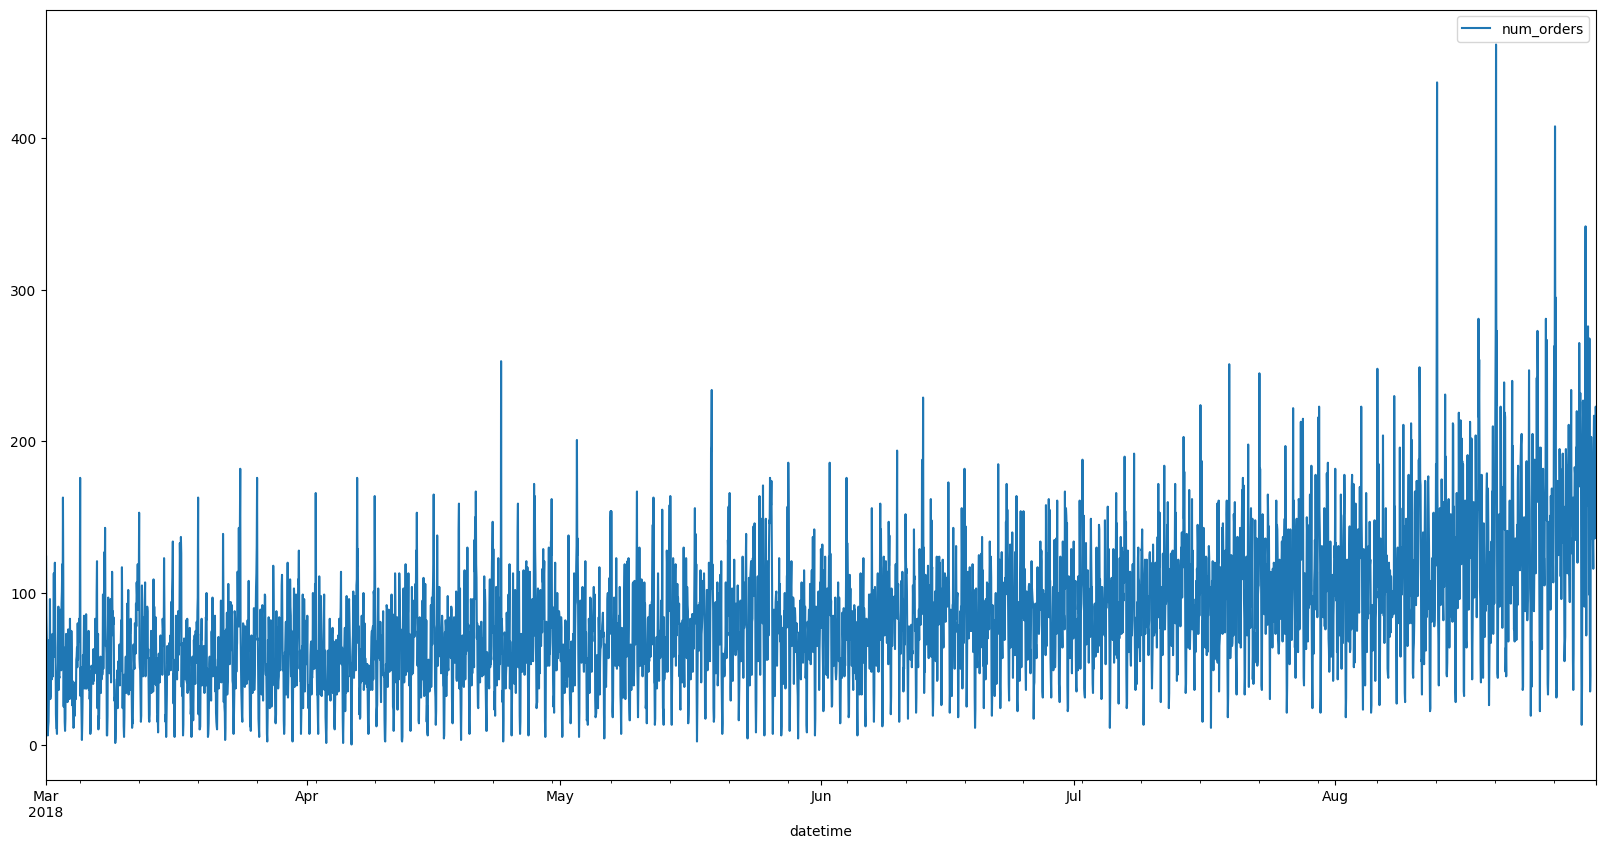

In [24]:
data = data.resample('1H').sum()
figsize = (20,10)
data.plot(figsize=figsize)

Общий график указывает на присутствие общего тренда.

In [25]:
decompose = seasonal_decompose(data)

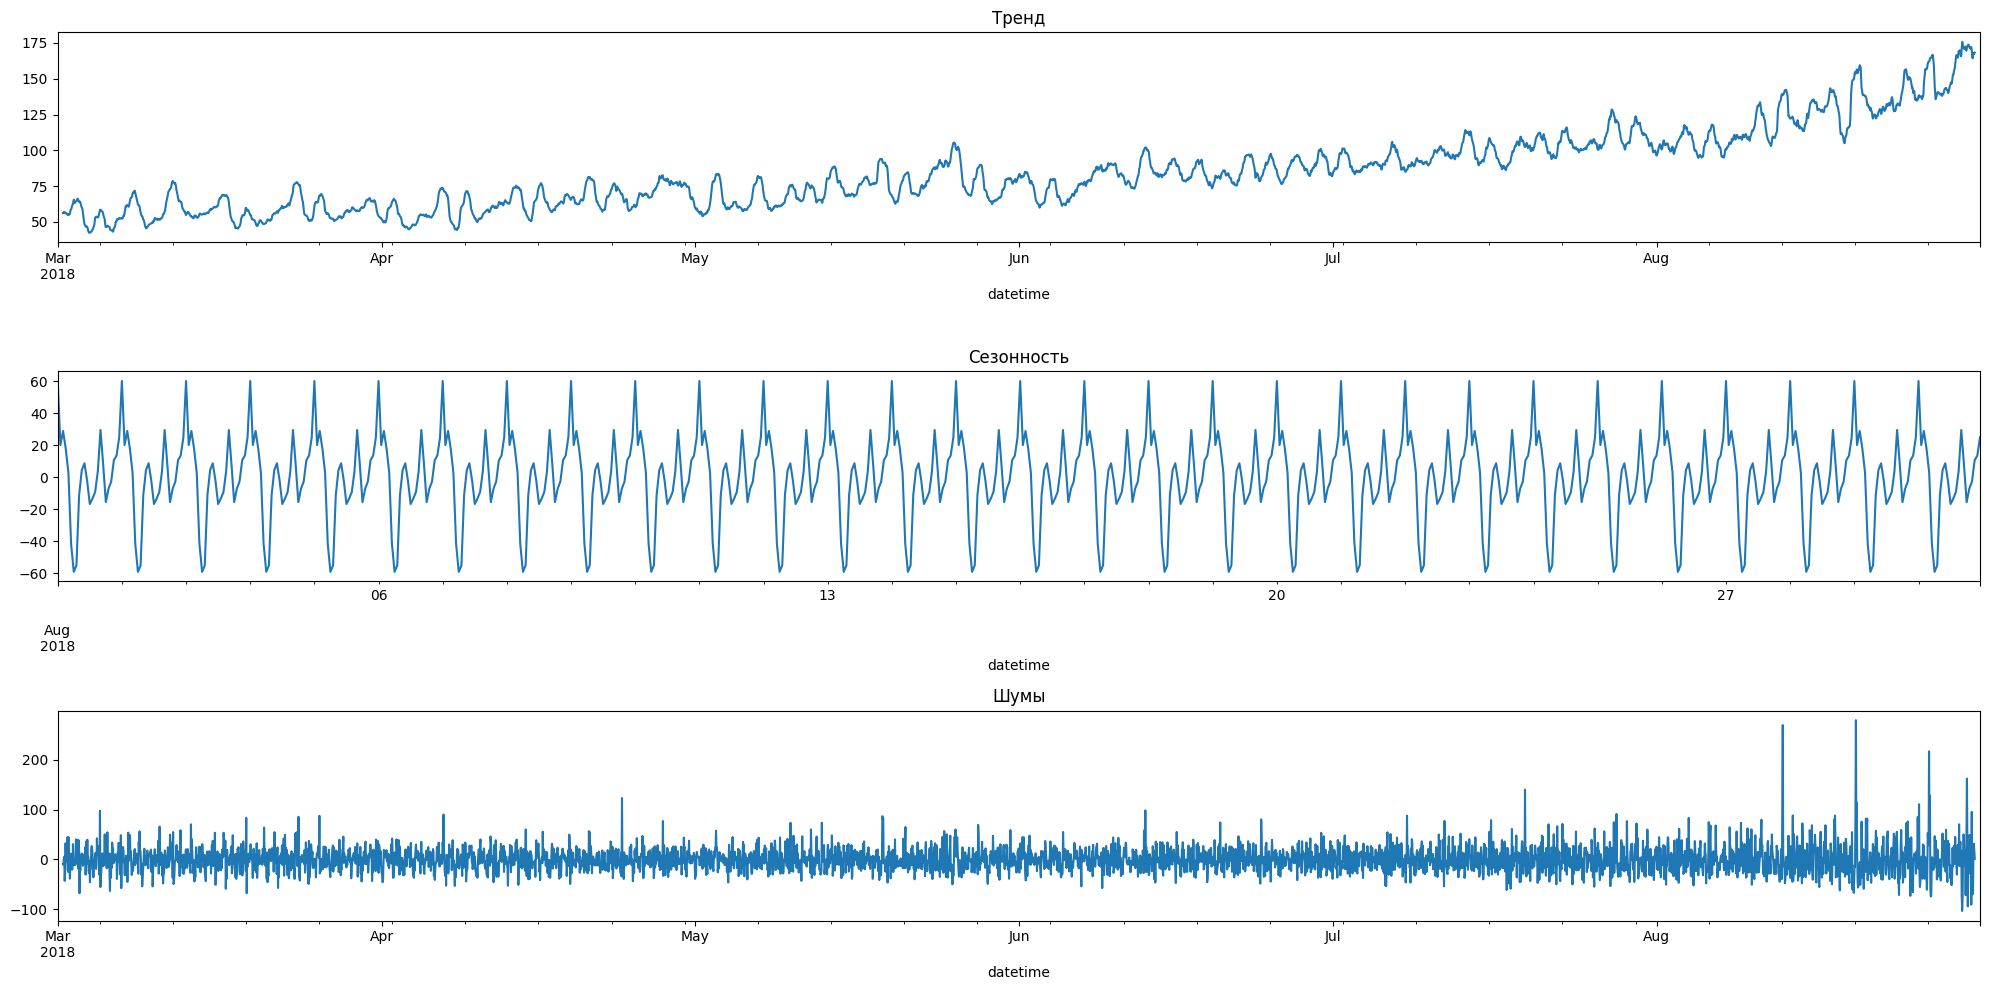

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decompose.seasonal['2018-08-01':'2018-08-30'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.tight_layout()

- Заметен явный восходящий тренд и всплеск заказов в августе.
- Заметно увеличение шумов в данных в конце графика.

In [27]:
data['rolling_mean'] = data.rolling(10).mean()

<Figure size 2000x1000 with 0 Axes>

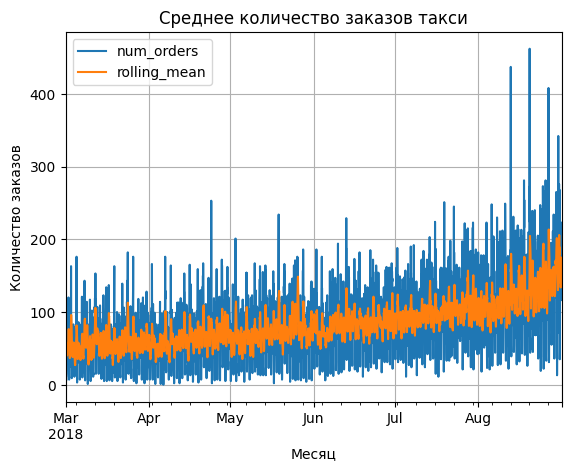

In [28]:
plt.figure(figsize=(20, 10))
data.plot()
plt.grid(True)
plt.title('Среднее количество заказов такси')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Результат скользящего среднего с окном в 10 дней показывает, что, в среднем, количество заказов такси растет.

In [29]:
def make_features(data, rolling_mean_size):

    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    decomposed = seasonal_decompose(data['num_orders'], period=24)

    for lag in range(1, 6):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['trend'] = decomposed.trend.shift(lag)
    data['seasonal'] = decomposed.seasonal.shift(lag)
    
    return data

data_resampled = data.copy()
data_resampled = make_features(data, 1)
data_resampled.shape

(4416, 13)

In [30]:
data_resampled.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,trend,seasonal
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,43.0,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,60.248112
2018-03-01 06:00:00,12,6.0,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,NaN,20.177074
2018-03-01 07:00:00,15,12.0,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,NaN,28.982743
2018-03-01 08:00:00,34,15.0,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,NaN,17.885407


In [31]:
data_resampled = data_resampled.dropna()
data_resampled.shape

(4392, 13)

In [32]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1, random_state=12345)

In [33]:
features_train, target_train = train.drop(['num_orders'], axis=1), train['num_orders']
features_test, target_test = test.drop(['num_orders'], axis=1), test['num_orders']

## Обучение

Создадим табличку для сравнения, куда внесем результаты работы наших моделей.

In [34]:
model_comparison = pd.DataFrame(columns=['Модель', 'RMSE'])

In [41]:
rcv_params = {'alpha': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

rcv = RidgeCV(alphas=rcv_params['alpha'], cv=TimeSeriesSplit(n_splits=5))
rcv.fit(features_train, target_train)
rcv_pred = rcv.predict(features_train)
rcv_rmse = mean_squared_error(target_train, rcv_pred) ** 0.5
model_comparison.loc[len(model_comparison)] = ['RidgeCV', rcv_rmse]

rcv_rmse

29.849804390962117

In [48]:
cbr_params = {'iterations': [200, 400, 600, 800, 1000],
                'learning_rate': [0.01, 0.1, 0.5, 1]}

cbr_model = CatBoostRegressor(random_state=12345, silent=True)

cbr_grid = GridSearchCV(cbr_model, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', param_grid=cbr_params)
cbr_grid.fit(features_train, target_train)
cbr_preds = cbr_grid.predict(features_train)
cbr_rmse = math.sqrt(-cbr_grid.best_score_)

print('Значение RMSE на обучающей выборке:', cbr_rmse)

model_comparison.loc[1] = ['CatBoostRegressor', cbr_rmse]

Значение RMSE на обучающей выборке: 25.190262663550698


In [53]:
lgb_params = {'n_estimators': [200, 400, 600, 800, 1000],
                'learning_rate': [0.01, 0.1, 0.5, 1]}
lgb_model = LGBMRegressor(random_state=12345)

lgb_grid = GridSearchCV(lgb_model, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', param_grid=lgb_params)
lgb_grid.fit(features_train, target_train)
lgb_preds = lgb_grid.predict(features_train)
lgb_rmse = math.sqrt(-lgb_grid.best_score_)

print('Значение RMSE на обучающей выборке:', lgb_rmse)

model_comparison.loc[2] = ['LGBMRegressor', lgb_rmse]

Значение RMSE на обучающей выборке: 25.438405630423205


In [54]:
best_rmse = model_comparison['RMSE'].min().round(2)
best_model = model_comparison["Модель"][model_comparison["RMSE"].idxmin()]

model_comparison

,Модель,RMSE
0,RidgeCV,29.849804
1,CatBoostRegressor,25.190263
2,LGBMRegressor,25.438406


In [55]:
print(f'Лучшей моделью с RMSE равным {best_rmse} оказалась {best_model}. Проверим её на тестовой выборке.')

Лучшей моделью с RMSE равным 25.19 оказалась CatBoostRegressor. Проверим её на тестовой выборке.


Кэтбуст показал себя лучше, чем ридж-регрессия и LGBM. Протестируем данную модель.

## Тестирование

In [57]:
best_model_predict = cbr_grid.predict(features_test)
test_rmse = mean_squared_error(target_test, best_model_predict, squared=False)
print('RMSE на тестовой выборке:', test_rmse)

RMSE на тестовой выборке: 40.37198707531063


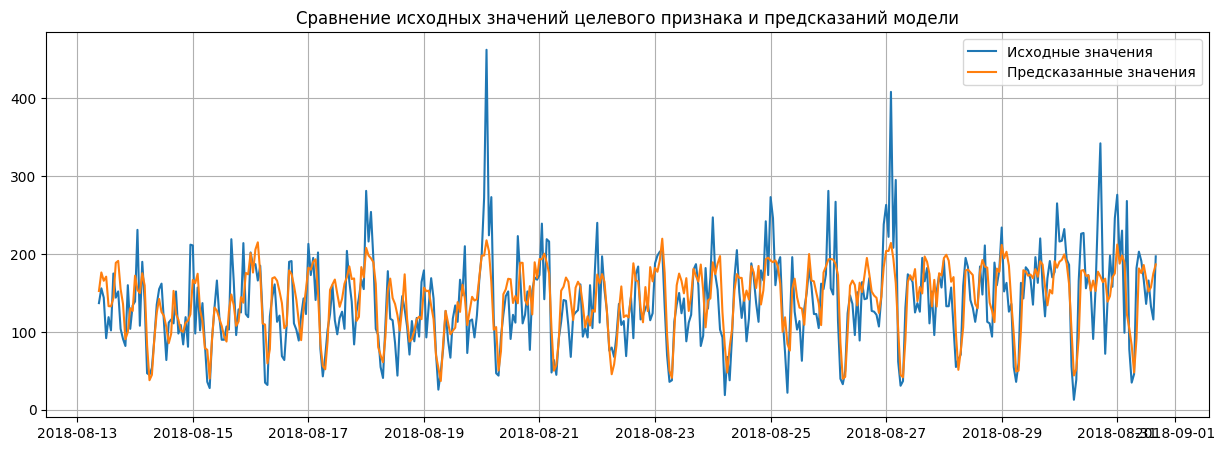

In [58]:
final_preds = pd.Series(lgb_grid.best_estimator_.predict(features_test), index=target_test.index)

plt.figure(figsize=(15,5))
plt.title("Сравнение исходных значений целевого признака и предсказаний модели")
plt.plot(target_test, label='Исходные значения')
plt.plot(final_preds, label ='Предсказанные значения')
plt.legend(loc="upper right")
plt.grid(True)

Кэтбуст подтвердил валидный результат на тестовой выборке. RMSE равна 40,4. <p>
Можно рекомендовать данную модель заказчику.